# Ex 05 -- 감성분석 실습

## 네이버 영화리뷰 감성분석

```
Naver Movie Review in Kor.
LSTM
1538/1538 - 3s - loss: 0.4803 - accuracy: 0.8360
[0.4803449809551239, 0.8359822630882263]

LSTM + dropout
1538/1538 - 3s - loss: 0.4339 - accuracy: 0.8401
[0.4338960647583008, 0.8401284217834473]

LSTM + recurrent dropout
1538/1538 - 15s - loss: 0.4224 - accuracy: 0.8430
[0.4223518371582031, 0.842994213104248]

Conv1D + word2vec_ko
1538/1538 - 3s - loss: 0.4907 - accuracy: 0.8325
[0.4907437562942505, 0.832466185092926]

LSTM + word2vec_ko + recurrent dropout
1538/1538 - 14s - loss: 0.3620 - accuracy: 0.8536
[0.3619636297225952, 0.8535628914833069]

LSTM Stacking + word2vec_ko + recurrent dropout 7th epoch
1538/1538 - 15s - loss: 0.3733 - accuracy: 0.8533
[0.3732941150665283, 0.8532986640930176]

GRU Stacking + word2vec_ko + recurrent dropout 8th epoch
1538/1538 - 26s - loss: 0.4981 - accuracy: 0.8481
[0.49807214736938477, 0.8481362462043762]
```
한국어에선 Conv1D를 활용한 모델이 성능이 조금 처지는 경향이 보인다. 어순의 차이 때문인듯.
Stacking은 성능향상이 거의 없어 보인다. 85%를 넘기는 지표는 drop-out 층을 추가한 덕이 크다.
GRU를 썼을 때 효율도 잘 안보이는 것 같다. 임베딩이 잘 학습되는 것과 지표가 잘 나오는 것은 살짝 다를 수도 있겠다는 생각.
모델은 과대적합이 되더라도 임베딩은 더 학습될 수 있을까?

학습된 임베딩과 사전학습된 임베딩 비교
```python
>>> word_vectors_lstm.similar_by_word("재미")
[('망각', 0.7869980335235596),
 ('마모루', 0.7856428027153015),
 ('캐', 0.7748635411262512),
 ('몰입', 0.7729829549789429),
 ('보트', 0.7706950902938843),
 ('마니', 0.7645766139030457),
 ('가치', 0.7612316012382507),
 ('긴장감', 0.7612043023109436),
 ('맛있', 0.7608613967895508),
 ('완전', 0.7575821876525879)]

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]
```

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.system("ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data")

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 

- 데이터의 중복 제거
- `NaN` 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

### 토크나이징 함수 코드 연습


```python
train_data.shape

import missingno as msno
msno.matrix(train_data)

for c in train_data.columns:
    print('{} : {}'.format(c, len(train_data.loc[pd.isnull(train_data[c]), c].values)))

train_data.loc[pd.isnull(train_data["document"]), "document"]

train_data = train_data.dropna(subset=["document", "label"])

# 본문과 레이블 값이 모두 동일한 중복치들을 제거한다.
train_data = train_data.drop_duplicates(subset=["document", "label"]) # , "label"

train_data

mecab = Mecab()
mecab.morphs(train_data["document"][4])

stopwords_set = set(stopwords)
train_tokens = []
train_tok_seqs = []
train_labels = []
for index, row in train_data.iterrows():
    # print(row['c1'], row['c2'])
    tokens = [t for t in mecab.morphs(row['document']) if not t in stopwords_set]
    if len(tokens)==0:
        print("nothing but stopwords")
        continue
    train_tokens += tokens
    train_tok_seqs.append(tokens)
    train_labels.append(row['label'])

print(
    f"train_tokens : {len(train_tokens)}\n",
    f"train_tok_seqs : {len(train_tok_seqs)}\n",
    f"train_labels :{len(train_labels)}\n",
)

train_tok_seqs[:5]

# train 데이터 문장들에 등장한 토큰의 빈도
tok_counts = Counter(train_tokens)

print(len(tok_counts), tok_counts.most_common(10))
# word_to_index

index_to_word = {(i+3):t[0] for i, t in enumerate(tok_counts.most_common(num_words))}
index_to_word.update({0:'<PAD>', 1:'<BOS>', 2:'<UNK>'})

len(index_to_word)

word_to_index = {t[0]:(i+3) for i, t in enumerate(tok_counts.most_common(num_words))}
word_to_index.update({'<PAD>':0, '<BOS>':1, '<UNK>':2})

num_words, word_to_index['영화']

train_emb_seqs = []
for seq in train_tok_seqs:
    emb_seq = [word_to_index.get(t, 2) for t in seq]
    train_emb_seqs.append(emb_seq)

train_emb_seqs[:5]
```

### 토큰화 후 인덱싱된 문장을 반환하는 함수

In [3]:
from konlpy.tag import Mecab
from collections import Counter

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

In [4]:
def mecab_tokenize(train_data=train_data, column='document', target='label',
                       stopwords=stopwords):
    tokenizer = Mecab()
    
    stopwords_set = set(stopwords)
    train_tok_seqs = []
    train_labels = []
    for index, row in train_data.iterrows():
        # print(row['c1'], row['c2'])
        tokens = [t for t in tokenizer.morphs(row[column]) if not t in stopwords_set]
        if len(tokens)==0:
            print("nothing but stopwords")
            continue
        train_tok_seqs.append(tokens)
        train_labels.append(row[target])
    
    return train_tok_seqs, train_labels

In [5]:
def load_data(train_data, test_data, num_words=10000):
    
    # 본문 또는 레이블 값이 없는 결측치들을 제거한다.
    train_data = train_data.dropna(subset=["document", "label"])
    test_data = test_data.dropna(subset=["document", "label"])
    
    # 본문과 레이블 값이 모두 동일한 중복치들을 제거한다.
    train_data = train_data.drop_duplicates(subset=["document", "label"]) # , "label"
    test_data = test_data.drop_duplicates(subset=["document", "label"]) # , "label"
    
    # KoNLPy 패키지의 MeCab-ko 분석기 클래스 활용
    train_tok_seqs, train_labels = mecab_tokenize(train_data, 'document', 'label')
    test_tok_seqs, test_labels = mecab_tokenize(test_data, 'document', 'label')

    # train 데이터 문장들에 등장한 토큰의 빈도
    tok_counts = Counter([t for seq in train_tok_seqs for t in seq])

    word_to_index = {t[0]:(i+3) for i, t in enumerate(tok_counts.most_common(num_words))}
    word_to_index.update({'<PAD>':0, '<BOS>':1, '<UNK>':2})

    train_emb_seqs = []
    for seq in train_tok_seqs:
        emb_seq = [word_to_index.get(t, 2) for t in seq]
        train_emb_seqs.append(emb_seq)

    test_emb_seqs = []
    for seq in test_tok_seqs:
        emb_seq = [word_to_index.get(t, 2) for t in seq]
        test_emb_seqs.append(emb_seq)
    
    # 특성 행렬과 호응을 위해 타겟 백터를 넘파이 자료형으로 변환; 아닐 시 에러 반환
    return train_emb_seqs, np.array(train_labels), test_emb_seqs, np.array(test_labels), word_to_index

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words)

nothing but stopwords
nothing but stopwords
nothing but stopwords
nothing but stopwords
nothing but stopwords


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
total_data_text = X_train + X_test
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.95564033589379
문장길이 최대 :  116
문장길이 표준편차 :  12.844422598641373
pad_sequences maxlen :  41
전체 문장의 0.9343656987388641%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
# 이때 X_train은 넘파이 자료형으로 반환 된 상태
print(X_train.shape)

(146336, 41)


In [15]:
X_train

array([[  31,   73,  918, ...,    0,    0,    0],
       [1027,    3,   10, ...,    0,    0,    0],
       [  23,  204,    2, ...,    0,    0,    0],
       ...,
       [ 153,    2,   17, ...,    0,    0,    0],
       [1051,    4, 2517, ...,    0,    0,    0],
       [ 180,    4, 1944, ...,    0,    0,    0]], dtype=int32)

In [16]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116179건
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

# print(partial_x_train.shape)
# print(partial_y_train.shape)

#### LTMS Model Training-Predetion

In [173]:
vocab_size = num_words    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)))
model.add(tf.keras.layers.LSTM(32, recurrent_dropout=.5, unroll=True))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(.5)) # 드롭아웃 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(
    optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
228/228 [==============================] - 23s 44ms/step - loss: 0.6078 - accuracy: 0.6747 - val_loss: 0.4874 - val_accuracy: 0.7914
Epoch 2/20
228/228 [==============================] - 8s 36ms/step - loss: 0.5269 - accuracy: 0.7850 - val_loss: 0.4860 - val_accuracy: 0.7923
Epoch 3/20
228/228 [==============================] - 8s 36ms/step - loss: 0.4795 - accuracy: 0.8148 - val_loss: 0.4082 - val_accuracy: 0.8327
Epoch 4/20
228/228 [==============================] - 8s 36ms/step - loss: 0.4307 - accuracy: 0.8407 - val_loss: 0.3870 - val_accuracy: 0.8386
Epoch 5/20
228/228 [==============================] - 8s 36ms/step - loss: 0.3982 - accuracy: 0.8522 - val_loss: 0.3701 - val_accuracy: 0.8412
Epoch 6/20
228/228 [==============================] - 8s 37ms/step - loss: 0.3745 - accuracy: 0.8607 - val_loss: 0.3797 - val_accuracy: 0.8455
Epoch 7/20
228/228 [==============================] - 8s 37ms/step - loss: 0.3577 - accuracy: 0.8678 - val_loss: 0.3664 - val_accuracy: 0.844

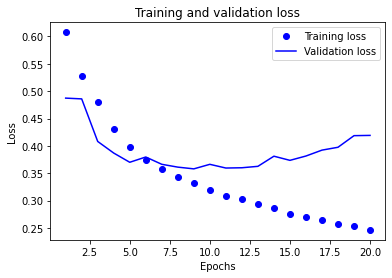

In [177]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

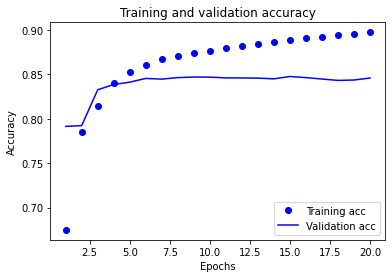

1538/1538 - 15s - loss: 0.4224 - accuracy: 0.8430
[0.4223518371582031, 0.842994213104248]


In [178]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

In [184]:
epochs=7 # 최적 적합 지점
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=0)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1538/1538 - 15s - loss: 0.5217 - accuracy: 0.8393
[0.521704912185669, 0.8392544984817505]


#### Conv1D Model Training-Predetion

In [135]:
vocab_size = num_words    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64
# vocab_size = 10
# word_vector_dim = 4


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(
    optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
228/228 [==============================] - 2s 6ms/step - loss: 0.4648 - accuracy: 0.7804 - val_loss: 0.3498 - val_accuracy: 0.8469
Epoch 2/20
228/228 [==============================] - 1s 5ms/step - loss: 0.3191 - accuracy: 0.8661 - val_loss: 0.3380 - val_accuracy: 0.8523
Epoch 3/20
228/228 [==============================] - 1s 5ms/step - loss: 0.2765 - accuracy: 0.8869 - val_loss: 0.3362 - val_accuracy: 0.8549
Epoch 4/20
228/228 [==============================] - 1s 5ms/step - loss: 0.2315 - accuracy: 0.9105 - val_loss: 0.3569 - val_accuracy: 0.8514
Epoch 5/20
228/228 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9347 - val_loss: 0.3889 - val_accuracy: 0.8445
Epoch 6/20
228/228 [==============================] - 1s 5ms/step - loss: 0.1317 - accuracy: 0.9553 - val_loss: 0.4522 - val_accuracy: 0.8402
Epoch 7/20
228/228 [==============================] - 1s 5ms/step - loss: 0.0943 - accuracy: 0.9694 - val_loss: 0.5144 - val_accuracy: 0.8324
Epoch 

In [136]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


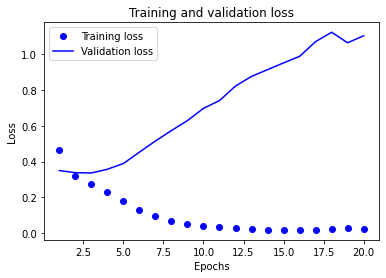

In [137]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

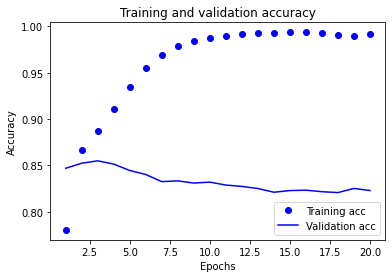

1538/1538 - 3s - loss: 1.1201 - accuracy: 0.8210
[1.1200588941574097, 0.8210031986236572]


In [138]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

In [139]:
epochs=3
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=0)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1538/1538 - 2s - loss: 1.1950 - accuracy: 0.8203
[1.1950390338897705, 0.8202512264251709]


#### GlobalMaxPooling1D Model Training-Predetion

In [211]:
vocab_size = num_words    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(
    optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.5270 - accuracy: 0.7776 - val_loss: 0.3724 - val_accuracy: 0.8372
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3355 - accuracy: 0.8562 - val_loss: 0.3406 - val_accuracy: 0.8493
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2883 - accuracy: 0.8801 - val_loss: 0.3389 - val_accuracy: 0.8524
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2554 - accuracy: 0.8967 - val_loss: 0.3472 - val_accuracy: 0.8521
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2265 - accuracy: 0.9110 - val_loss: 0.3609 - val_accuracy: 0.8524
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1987 - accuracy: 0.9248 - val_loss: 0.3780 - val_accuracy: 0.8502
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1723 - accuracy: 0.9370 - val_loss: 0.4005 - val_accuracy: 0.8463
Epoch 

In [212]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


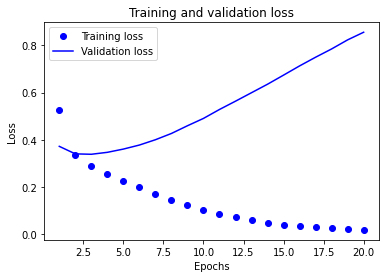

In [213]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

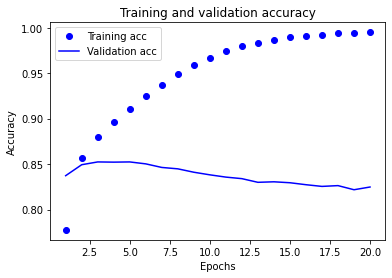

1538/1538 - 2s - loss: 0.8595 - accuracy: 0.8209
[0.8595306873321533, 0.8208609223365784]


In [214]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

### 임베딩 벡터 추출

In [185]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)b

(10000, 64)


In [186]:
vectors = model.get_weights()[0]
len(vectors)

10000

In [187]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_kor.txt'

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))

In [188]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors_lstm['영화']
vector

array([-0.0633241 , -0.03915964,  0.11795199, -0.0052815 ,  0.04227443,
       -0.06000474, -0.05582763,  0.01987036, -0.0112064 ,  0.07230794,
       -0.04851288, -0.08225393,  0.03454892,  0.04138022, -0.01028074,
        0.04797602, -0.01152341, -0.01748088,  0.03982136, -0.09611604,
       -0.04576351,  0.04005467, -0.01362292, -0.02546351, -0.02595228,
        0.01227347, -0.0315112 ,  0.03192014,  0.08520109, -0.00285222,
       -0.05756396,  0.00276829, -0.04961812,  0.05820467,  0.03897576,
        0.00558604, -0.05525676, -0.11419272, -0.02109938,  0.00322495,
       -0.11719435,  0.02697829, -0.00257999,  0.11228397, -0.00368758,
        0.06625979,  0.02308918,  0.03489112,  0.01761463, -0.13628878,
        0.05643692, -0.00847419,  0.0226559 , -0.0225627 ,  0.04344964,
        0.04664984,  0.00376097,  0.10092533, -0.03697559, -0.02482015,
        0.05239385, -0.02116383, -0.04918092, -0.01290834], dtype=float32)

In [189]:
word_vectors_lstm.similar_by_word("재미")

[('망각', 0.8039290904998779),
 ('긴장감', 0.8004361987113953),
 ('퍼센트', 0.7974274158477783),
 ('따르', 0.7803413271903992),
 ('아무거', 0.7792147397994995),
 ('했으니', 0.7748521566390991),
 ('각종', 0.7657678723335266),
 ('보트', 0.7647290229797363),
 ('대화', 0.7633835673332214),
 ('몰입', 0.7610213160514832)]

### Google pretrained word embedding model

In [221]:
os.system("ln -s ~/data/word2vec_ko* ~/aiffel/sentiment_classification/data")

0

In [47]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
word_vectors = Word2VecKeyedVectors.load(word2vec_path)

vector = word_vectors.wv['영화']
vec_size = len(vector)
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [45]:
word_vectors.wv.similar_by_word('재미')

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

### 사전학습 임베딩을 이용한 전이 학습

In [52]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = vec_size  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [53]:
from tensorflow.keras.initializers import Constant

#### Conv1D 층을 이용한 전이 학습

In [125]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(.5))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

In [126]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
228/228 [==============================] - 3s 9ms/step - loss: 0.6772 - accuracy: 0.5551 - val_loss: 0.5893 - val_accuracy: 0.7156
Epoch 2/20
228/228 [==============================] - 2s 7ms/step - loss: 0.5405 - accuracy: 0.7253 - val_loss: 0.4588 - val_accuracy: 0.7877
Epoch 3/20
228/228 [==============================] - 2s 7ms/step - loss: 0.4349 - accuracy: 0.8046 - val_loss: 0.4085 - val_accuracy: 0.8166
Epoch 4/20
228/228 [==============================] - 2s 7ms/step - loss: 0.3811 - accuracy: 0.8336 - val_loss: 0.3812 - val_accuracy: 0.8333
Epoch 5/20
228/228 [==============================] - 2s 7ms/step - loss: 0.3448 - accuracy: 0.8528 - val_loss: 0.3618 - val_accuracy: 0.8404
Epoch 6/20
228/228 [==============================] - 2s 7ms/step - loss: 0.3182 - accuracy: 0.8667 - val_loss: 0.3528 - val_accuracy: 0.8429
Epoch 7/20
228/228 [==============================] - 2s 7ms/step - loss: 0.2965 - accuracy: 0.8776 - val_loss: 0.3509 - val_accuracy: 0.8465
Epoch 

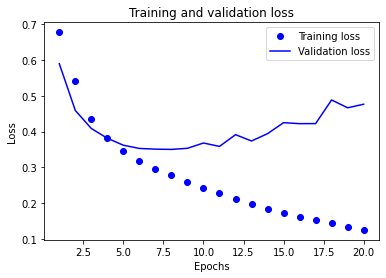

In [127]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

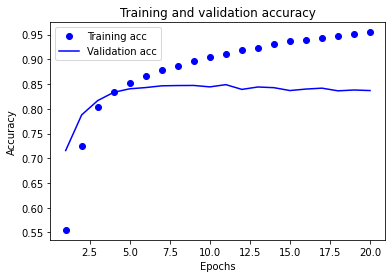

1538/1538 - 3s - loss: 0.4907 - accuracy: 0.8325
[0.4907437562942505, 0.832466185092926]


In [128]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

#### LSTM 층을 이용한 전이 학습

In [115]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                 embeddings_initializer=Constant(embedding_matrix),  
                 input_length=maxlen, trainable=True)) # trainable을 True로 주면 Fine-tuning
# 순환 드롭아웃 기법 활용, w. unrolling the layer
model.add(tf.keras.layers.LSTM(32, recurrent_dropout=.5, unroll=True))
# 드롭아웃 기법 활용
model.add(tf.keras.layers.Dropout(.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
gru (GRU)                    (None, 41, 32)            12864     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 1,019,745
Trainable params: 1,019,745
Non-trainable params: 0
___________________________________________

In [116]:
epochs=20
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
228/228 [==============================] - 55s 93ms/step - loss: 0.6923 - accuracy: 0.5093 - val_loss: 0.6857 - val_accuracy: 0.5212
Epoch 2/20
228/228 [==============================] - 16s 70ms/step - loss: 0.5233 - accuracy: 0.7380 - val_loss: 0.3966 - val_accuracy: 0.8216
Epoch 3/20
228/228 [==============================] - 16s 71ms/step - loss: 0.3821 - accuracy: 0.8337 - val_loss: 0.3508 - val_accuracy: 0.8454
Epoch 4/20
228/228 [==============================] - 16s 70ms/step - loss: 0.3426 - accuracy: 0.8538 - val_loss: 0.3350 - val_accuracy: 0.8526
Epoch 5/20
228/228 [==============================] - 16s 71ms/step - loss: 0.3192 - accuracy: 0.8656 - val_loss: 0.3325 - val_accuracy: 0.8536
Epoch 6/20
228/228 [==============================] - 16s 70ms/step - loss: 0.3032 - accuracy: 0.8739 - val_loss: 0.3276 - val_accuracy: 0.8577
Epoch 7/20
228/228 [==============================] - 16s 71ms/step - loss: 0.2897 - accuracy: 0.8794 - val_loss: 0.3262 - val_accuracy:

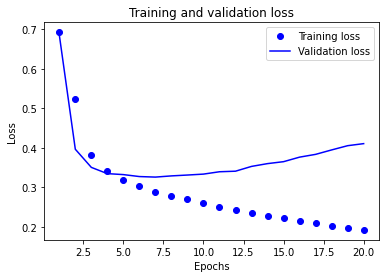

In [117]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

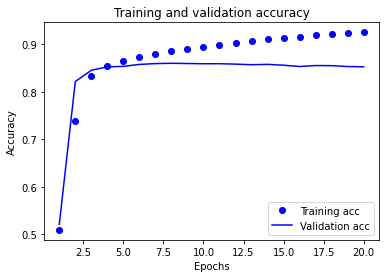

1538/1538 - 26s - loss: 0.4119 - accuracy: 0.8524
[0.41192078590393066, 0.852424681186676]


In [118]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

In [119]:
epochs=8
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=0)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1538/1538 - 26s - loss: 0.4981 - accuracy: 0.8481
[0.49807214736938477, 0.8481362462043762]


#### LSTM 스태킹 기법 사용

In [110]:
# model = tf.keras.Sequential()
in_x = tf.keras.Input(shape=(maxlen,))
embed_x = tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
             embeddings_initializer=Constant(embedding_matrix), #input_length=maxlen,
                                     trainable=True)(in_x) # trainable을 True로 주면 Fine-tuning

# 순환 드롭아웃 기법 활용, w. unrolling the layer
# 여기에 return_sequences=True인자를 안 넣고 삽질로 함수형 API로 바꿨다.
# 스태킹 기법은 시퀀셜 모델로 만들어도 작동한다.
x = tf.keras.layers.LSTM(32, recurrent_dropout=.2, 
                     return_sequences=True, unroll=True)(embed_x)
# 순환층 스태킹 기법
x = tf.keras.layers.LSTM(32, recurrent_dropout=.2, unroll=True)(x)
# 드롭아웃 기법 활용
# x = tf.keras.layers.Dropout(.5)(embed_x)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=in_x, outputs=out)
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 41, 32)            17024     
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17  

#### GRU 스태킹 기법 사용

In [130]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                 embeddings_initializer=Constant(embedding_matrix),  
                 input_length=maxlen, trainable=True)) # trainable을 True로 주면 Fine-tuning
# 순환 드롭아웃 기법 활용, w. unrolling the layer
model.add(tf.keras.layers.GRU(32, recurrent_dropout=.5, unroll=True, return_sequences=True))
model.add(tf.keras.layers.GRU(32, recurrent_dropout=.5, unroll=True))
# 드롭아웃 기법 활용
model.add(tf.keras.layers.Dropout(.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 41, 32)            12864     
_________________________________________________________________
dropout_18 (Dropout)         (None, 41, 32)            0         
_________________________________________________________________
dense_48 (Dense)             (None, 41, 16)            528       
_________________________________________________________________
dense_49 (Dense)             (None, 41, 1)             17        
Total params: 1,013,409
Trainable params: 1,013,409
Non-trainable params: 0
_________________________________________________________________


In [131]:
epochs=20
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
228/228 [==============================] - 30s 50ms/step - loss: 0.6099 - accuracy: 0.6495 - val_loss: 0.4725 - val_accuracy: 0.7735
Epoch 2/20
228/228 [==============================] - 9s 38ms/step - loss: 0.4692 - accuracy: 0.7781 - val_loss: 0.4167 - val_accuracy: 0.8054
Epoch 3/20
228/228 [==============================] - 9s 38ms/step - loss: 0.4261 - accuracy: 0.8031 - val_loss: 0.3980 - val_accuracy: 0.8149
Epoch 4/20
228/228 [==============================] - 9s 38ms/step - loss: 0.4033 - accuracy: 0.8154 - val_loss: 0.3889 - val_accuracy: 0.8205
Epoch 5/20
228/228 [==============================] - 9s 38ms/step - loss: 0.3885 - accuracy: 0.8235 - val_loss: 0.3875 - val_accuracy: 0.8216
Epoch 6/20
228/228 [==============================] - 9s 38ms/step - loss: 0.3781 - accuracy: 0.8289 - val_loss: 0.3828 - val_accuracy: 0.8244
Epoch 7/20
228/228 [==============================] - 9s 38ms/step - loss: 0.3701 - accuracy: 0.8333 - val_loss: 0.3809 - val_accuracy: 0.825

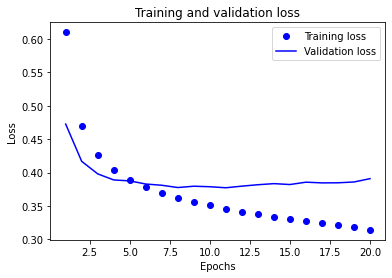

In [132]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

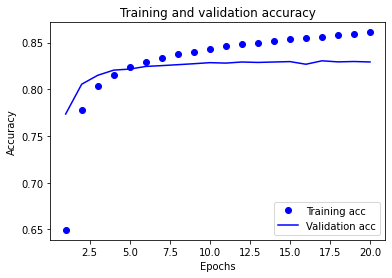

1538/1538 - 15s - loss: 0.3912 - accuracy: 0.8290
[0.3911742866039276, 0.8290160298347473]


In [133]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

In [134]:
epochs=7
history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
            batch_size=512,validation_data=(x_val, y_val),verbose=0)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1538/1538 - 15s - loss: 0.3987 - accuracy: 0.8285
[0.3986968696117401, 0.8284562826156616]
